In [42]:
import normalize
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score, precision_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest, RFE, VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import SMOTE
import pandas as pd 
import numpy as np 
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
%matplotlib inline

# Methods

In [43]:
def show_kbest(data_frame, target, linear_rel=True, k=4):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    scores = []
    if linear_rel == True: 
        feat_selector = SelectKBest(f_classif, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "F Score"
    else:
        feat_selector = SelectKBest(mutual_info_classif, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "Mutual Information"
    
    feat_scores = pd.DataFrame()
    feat_scores[col_name] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 

def preprocess_data_frame(data_frame, columns):
    """
    Dummifying and encoding variables of dataframe, droping rows with NAN values
    :param data_frame: A pandas DataFrame to be processed
    pandas DataFrame
    :param columns: List of column names of categorical variables 
    :returns data_frame: encoded variable DataFrame
    """
    data_frame = data_frame.dropna()
    data_frame = data_frame.reset_index(drop=True)
    
    for col in columns:
#         print(data_frame[col])
        data_frame[col] = encode_variable(data_frame[col])
#         print(data_frame[col])
    data_frame = pd.get_dummies(data_frame)
    return data_frame
    
def encode_variable(series):
    """
    Encoding categorical variables to numericial values
    :param series: A pandas Series with categorical values
    pandas DataFrame
    :returns data_frame: encoded variable DataFrame
    """
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(series)
    print(list(le.classes_))
    print(set(le.transform(series))) 
    data_frame = pd.DataFrame({
        series.name: le.transform(series)
    })
    return data_frame
    
def split_dataframe(data_frame, target):
    """
    Split dataframe to predictors and target
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :returns DataFrames: X (predictors) and y (target) dataframes 
    """
    X = data_frame.drop([target], axis=1)
    y = encode_variable(data_frame[target])
    return X, y 

def get_features_variance_threshold(data_frame,target="gender", threshold=0.2):
    """
    Returns list of features with a variance above the specified threshold
    :param data_frame: A pandas dataFrame with the training data
    :param threshold: float value between 0 and 1 
    :returns feature_scores: list of features
    """
    if target in data_frame.columns:
        data_frame = data_frame.drop([target], axis=1)
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(data_frame)
    # Get the indices of zero variance feats
    feat_ix_keep = selector.get_support(indices=True)
#     print(feat_ix_keep)
    return data_frame.columns[feat_ix_keep]

def get_features_univariate(data_frame, k=5, linear=True, target="gender"):
    """
    Returns list of features selected using the specified univariate method
    :param data_frame: A pandas dataFrame with the training data
    :param k: top k features to select  
    :returns data_frame: with selected features
    """
    df = show_kbest(data_frame,target=target,linear_rel=linear, k=k)
    df = df[df["Support"] == True]
    columns = df["Attribute"].values
    return columns

def get_features_rfe(data_frame,model,k=5):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame.drop("gender", axis=1)
    y = data_frame["gender"]
    selector = RFE(model, k, step=1)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return list(df[df["support"] == True]["feature"])

    
    
def under_sample(X,y):
    """ Returns resampled features and labels
    :param X: Features data frame
    :param y: Label data frame
    :return X_resampled, y_resampled: Numpy features array and corresponding lable array
    """
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_sample(X, y)
    print(sorted(Counter(y_resampled).items()))
    return X_resampled, y_resampled

def generate_classification_report(X_train, X_test, y_train, y_test, model):
    """ Prints classification report
    :param X: Features data frame
    :param y: Label data frame
    :param model: Sklearn model object
    """
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#     y_test = list(np.array(y_test).flatten())
#     y_train = list(np.array(y_train).flatten())
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    target_names = ['female', 'male']
    mean = cross_val_score(model, X_test, y_test, cv=10, scoring="accuracy").mean()
    var = cross_val_score(model, X_test, y_test, cv=10, scoring="accuracy").var()
#     print("Cross Validated Accuracy: mean - {}, var - {}".format(mean, var))
    print("Accuracy Score: {} Var: {}".format(mean, var))
    print("\nConfusion Matrix:\n")
    print(confusion_matrix(y_test, pred))
    print("\nClassification Report:\n")
    print(classification_report(y_test, pred, target_names=target_names))
    
def change_of_evaluation_rfe(X_train, X_test,y_train,y_test,model, metric="precision"):
    """
    Plots accuracy with respect to the number of features left, and prints the names of features
    :param X_train: A pandas dataFrame with train features
    :param X_test: A pandas dataFrame with test features
    :param y_train: A pandas dataFrame with train labels
    :param y_test: A pandas dataFrame with test labels
    :param model: Sklearn classification model object
    :param metric: Metric to show: precision, recall, accuracy
    :return num_features: Returns the top k features to be selected
    """
    base = pd.concat([pd.concat([X_train,X_test]), pd.concat([y_train,y_test])], axis=1)
    X = pd.concat([X_train,X_test])
    y = pd.concat([y_train,y_test])
    score = []
    for k in range(len(X.columns),0,-1):
        columns = get_features_rfe(base,model,k)
        X_tr = X_train[columns]
        X_te = X_test[columns]

        model.fit(X_tr, y_train)
        mean = cross_val_score(model, X_te, y_test, cv=10, scoring=metric).mean()
        variance = cross_val_score(model, X_te, y_test, cv=10).var()

        score.append([k, mean, variance])

    df = pd.DataFrame(score, columns=["num_features", "mean","variance"])
    sns.pointplot(df["num_features"], df["mean"])
    plt.show()
    return df.sort_values("mean", ascending=False)[["num_features"]].values[0][0]

def change_of_evaluation_univariate_feature_selection(X_train, X_test, y_train, y_test,model, metric="precision", linear=True):
    """
    Plots accuracy with respect to the number of features left, and prints the names of features
    :param X_train: A pandas dataFrame with train features
    :param X_test: A pandas dataFrame with test features
    :param y_train: A pandas dataFrame with train labels
    :param y_test: A pandas dataFrame with test labels
    :param linear: If true > F-score if false > mutual information
    :param model: Sklearn classification model object
    :param metric: Metric to show: precision, recall, accuracy
    :return num_features: Returns the top k features to be selected
    """
    X = pd.concat([X_train,X_test])
    y = pd.concat([y_train,y_test])
    data = pd.concat([X,y], axis=1)
    score = []
    for k in range(len(X.columns),0,-1):
        df = show_kbest(data,"gender",linear_rel=linear, k=k)
        df = df[df["Support"] == True]
        columns = df["Attribute"].values
        X_tr = X_train[columns]
        X_ts = X_test[columns]

        model.fit(X_tr, y_train)
        mean = cross_val_score(model, X_ts, y_test, cv=10, scoring=metric).mean()
        variance = cross_val_score(model, X_ts, y_test, cv=10).var()

        score.append([k, mean, variance])

    df = pd.DataFrame(score, columns=["num_features", "mean","variance"])
    sns.pointplot(df["num_features"], df["mean"])
    plt.show()
    return df.sort_values("mean", ascending=False)[["num_features"]].values[0][0]

def change_of_evaluation_variance_threshold(X_train, X_test, y_train, y_test,model,metric="precision"):
    """
    Plots accuracy with respect to the number of features left, and prints the names of features
    :param X_train: A pandas dataFrame with train features
    :param X_test: A pandas dataFrame with test features
    :param y_train: A pandas dataFrame with train labels
    :param y_test: A pandas dataFrame with test labels
    :param model: Sklearn classification model object
    :param metric: Metric to show: precision, recall, accuracy
    """
    lst = list(np.arange(0.0, 1.0, 0.1))
    X = pd.concat([X_train,X_test])
    y = pd.concat([y_train,y_test])
    score = []
    for k in lst:
        features = get_features_variance_threshold(X, threshold=k)
        
        X_train = X_train[features]
        X_test = X_test[features]
        
#         print("Variance: {} - features: {}".format(k,features))

        model.fit(X_train, y_train)
        mean = cross_val_score(model, X_test, y_test, cv=10).mean()
        variance = cross_val_score(model, X_test, y_test, cv=10).var()
        score.append([k, mean, variance])
#     print(score)
    df = pd.DataFrame(score, columns=["variance", "mean", "std"])
    sns.pointplot(df["variance"], df["mean"])
    plt.show()
    return df.sort_values("mean", ascending=False)[["variance"]].values[0][0]
    
def full_report(X_train, X_test, y_train, y_test, model):
    """ Prints classification report for model over different feature selection models
    :param X_train: A pandas dataFrame with train features
    :param X_test: A pandas dataFrame with test features
    :param y_train: A pandas dataFrame with train labels
    :param y_test: A pandas dataFrame with test labels
    :param model: Sklearn object
    """
    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])
    
    base = pd.concat([X,y], axis=1)
    print("""###############################################################""")
    print("""Feature Selection: F-SCORE: \n""")
    k = change_of_evaluation_univariate_feature_selection(X_train, X_test, y_train, y_test,
                                                              model, metric="accuracy")
    features = get_features_univariate(base, k=k, linear=True)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_train, X_test, y_train, y_test, r_forest)
    print("""###############################################################""")
    print("""Feature Selection: MUTUAL INFORMATION: \n""")

    k = change_of_evaluation_univariate_feature_selection(X_train, X_test, y_train, y_test,
                                                              model,linear=False, metric="accuracy")
    features = get_features_univariate(base, k=k, linear=False)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_train, X_test, y_train, y_test, r_forest)
    print("""###############################################################""")
    print("""Feature Selection: Variance Threshold: \n""")
    v = change_of_evaluation_variance_threshold(X_train, X_test, y_train, y_test,model, metric="accuracy")
#     print(v)
    features = get_features_variance_threshold(base,threshold=v)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_train, X_test, y_train, y_test, r_forest)
    
    print("""###############################################################""")
    print("""Feature Selection: RFE: \n""")
    k = change_of_evaluation_rfe(X_train, X_test, y_train, y_test,
                                 model,metric='accuracy')
    features = get_features_rfe(base,model, k=k)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_train, X_test, y_train, y_test, model)



In [44]:
def over_sample(X,y):
    """
    Does the hybrid oversampling with SMOTE
    :param X: Dataframe with predictor atributes
    :param y: Dataframe with labels
    :return X_resampled, y_resampled:
    """
    sm = SMOTE(random_state=42)
    X,y = sm.fit_sample(X, y)
    print(X.shape, y.shape)
    return X,y

def train_test_dfs(X,y,test_size=0.2):
    """
    Returns train, test dataframees
    :parma X: data frame with predictor atributes 
    :parma y: data frame with labels 
    :parma test_size: fraction of data set to be assigned to the test set
    :return X_train, X_test, y_train, y_test:
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)
    y_train = pd.DataFrame(y_train, columns=y.columns)
    y_test = pd.DataFrame(y_test, columns=y.columns)
    return X_train, X_test, y_train, y_test

def evaluate_model(estimator, X_train, X_test, y_train, y_test): 
    """
    Prints accuracy, confusion matrix and classification report
    """
    target_names = ['female', 'male']
    estimator.fit(X_train,y_train)
    print(accuracy_score(y_test, estimator.predict(X_test)))
    print(confusion_matrix(y_test, estimator.predict(X_test)))
    print(classification_report(y_test, estimator.predict(X_test), target_names=target_names))
    
def get_ac_pr_re_f1(estimator, X,y):
    """
    Returns:
    Accuracy, Precission, Recall, F1-Score
    """
    estimator.fit(X_train,y_train)
    predict = estimator.predict(X_test)
    acc = cross_val_score(estimator, X,y,scoring="accuracy", cv=10).mean()
    re = cross_val_score(estimator, X,y,scoring="recall", cv=10).mean()
    pr = cross_val_score(estimator, X,y,scoring="precision", cv=10).mean()
    f1 = cross_val_score(estimator, X,y,scoring="f1", cv=10).mean()
    return acc,pr,re,f1

def model_comparison_df(estimator_dict, X,y):
    """
    Returns table with model performance comparisson
    """
    lst = []
    for k,v in estimator_dict.items():
        acc, pr, re, f1 = get_ac_pr_re_f1(v, X,y)
        lst.append([k, acc, pr, re, f1])
    return pd.DataFrame(lst, columns=["Algorithm", "Accuracy", "Precision", "Recall", "F1"])

def print_latex(df, col_format="|c|c|c|c|c|"):
    """ Prints the latex syntax equivalent to the passed dataframe
    :param df: Pandas dataframe 
    :col_format : String indicating the format of columns
    """
    df = df.round(2)
    latex = df.to_latex(column_format=col_format, index=False).replace('toprule',
                                            "hline").replace('midrule',
                                            "hline").replace('bottomrule',
                                            "hline").replace("\\\\\n",
                                            "\\\\\n\\hline").replace("\hline\hline","\hline")
    print(latex)

In [45]:
# get_ac_pr_re_f1(r_forest,X_over,y_over)

# Load the data

In [46]:
data = pd.read_pickle("../data/final_sets/countries/model_large/2016_german")

# Preprocess and Normalize

In [47]:
data = preprocess_data_frame(data, ["gender"])
data.gender.value_counts()

['female', 'male']
{0, 1}


1    1136
0     171
Name: gender, dtype: int64

   index  gender  entered  efficiency  eig_central  in_degree    k_core  \
0      0       1     2011     0.72752    -0.293665  -0.716639 -0.957751   

   out_degree     views  age       ...         party1  party2  party3  \
0    -0.69084 -0.360073   70       ...              0       0       0   

   other_p  is_alive_no  is_alive_unknown  is_alive_yes  year_interval_1  \
0        1            1                 0             0                0   

   year_interval_2  year_interval_3  
0                0                1  

[1 rows x 37 columns]


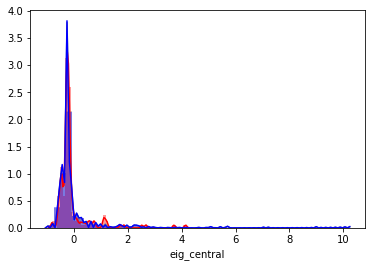

In [48]:
data = normalize.zscore_wikipedia_entered(data, ["views", "eig_central","in_degree","k_core","out_degree","efficiency"])
print(data.head(1))
data.head()

sns.distplot(data.eig_central, color="grey")
sns.distplot(data[data["gender"]==0].eig_central, color="red")
sns.distplot(data[data["gender"]==1].eig_central, color="blue")



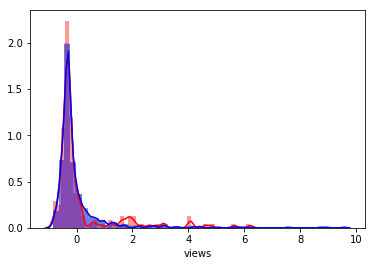

In [49]:
sns.distplot(data.views, color="grey")
sns.distplot(data[data["gender"]==0].views, color="red")
sns.distplot(data[data["gender"]==1].views, color="blue")



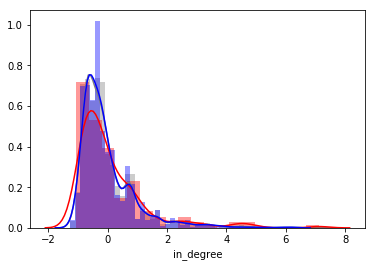

In [50]:
sns.distplot(data.in_degree, color="grey")
sns.distplot(data[data["gender"]==0].in_degree, color="red")
sns.distplot(data[data["gender"]==1].in_degree, color="blue")


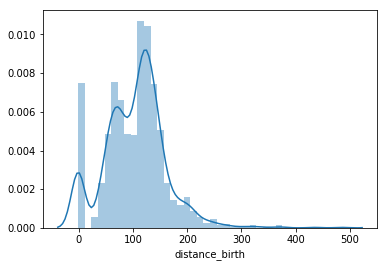

In [51]:
sns.distplot(data["distance_birth"])

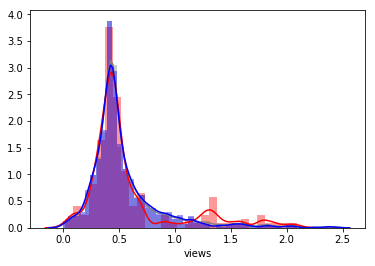

In [52]:
data = normalize.normalize(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])

sns.distplot(data.views, color="grey")
sns.distplot(data[data["gender"]==0].views, color="red")
sns.distplot(data[data["gender"]==1].views, color="blue")
#data["views"].hist()

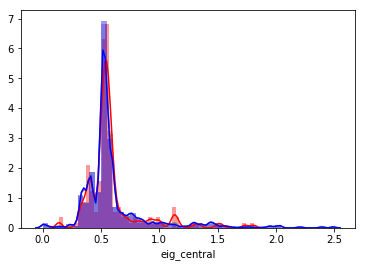

In [53]:
sns.distplot(data.eig_central, color="grey")
sns.distplot(data[data["gender"]==0].eig_central, color="red")
sns.distplot(data[data["gender"]==1].eig_central, color="blue")

In [ ]:
sns.distplot(data.in_degree, color="grey")
sns.distplot(data[data["gender"]==0].in_degree, color="red")
sns.distplot(data[data["gender"]==1].in_degree, color="blue")

In [54]:
data.shape

(1307, 37)

In [55]:
data.gender.value_counts()

1    1136
0     171
Name: gender, dtype: int64

# Machine Learning

In [56]:
X,y=split_dataframe(data,"gender")

[0, 1]
{0, 1}


In [57]:
X.head()

,index,entered,efficiency,eig_central,in_degree,k_core,out_degree,views,age,distance_birth,...,party1,party2,party3,other_p,is_alive_no,is_alive_unknown,is_alive_yes,year_interval_1,year_interval_2,year_interval_3
0,0,2011,1.731900,0.505491,0.433983,0.729934,0.511861,0.400914,70,142,...,0,0,0,1,1,0,0,0,0,1
1,1,2012,1.644144,0.531275,1.127265,1.385309,0.941523,0.371223,73,128,...,0,0,0,1,1,0,0,0,0,1
2,2,2009,1.253683,0.526813,0.405586,1.212989,1.070414,1.895638,60,114,...,0,0,0,1,1,0,0,0,1,0
3,3,2009,1.731099,0.526968,0.695952,0.945783,0.581808,0.403154,71,103,...,0,0,0,1,1,0,0,0,1,0
4,4,2011,1.419928,2.031013,1.000702,1.269519,0.784610,1.693024,48,166,...,0,0,0,1,1,0,0,0,0,1


In [58]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# y_test = list(np.array(y_test.values).flatten())
# y_train = list(np.array(y_train.values).flatten())

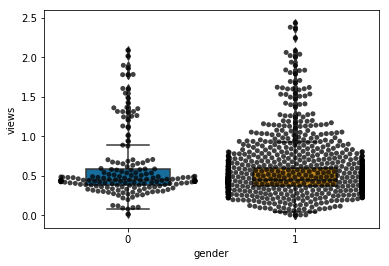

In [59]:
#data.boxplot(column="views", by="gender")

# plot boxplot with seaborn
bplot=sns.boxplot(y='views', x='gender', 
                 data=data, 
                 width=0.5,
                 palette="colorblind")
 
# add swarmplot
bplot=sns.swarmplot(y='views', x='gender',
              data=data, 
              color='black',
              alpha=0.75)


# Algorithms

In [60]:
# SVM
s_vm = svm.SVC()
# Logistic regression
log_reg = LogisticRegression()
# Decision Tree
d_tree = tree.DecisionTreeClassifier()
# Random Forest
r_forest = RandomForestClassifier()

estimator_dict = {
    "SVM": s_vm,
    "Logistic Regression": log_reg,
    "Decision Tree": d_tree,
    "Random Forest": r_forest
}

# Oversampling 

In [61]:
X_over, y_over = over_sample(X,y)
X_over = pd.DataFrame(X_over, columns=X.columns)
y_over = pd.DataFrame(y_over, columns=["gender"])
y_over["gender"].value_counts()

(2272, 36) (2272,)


1    1136
0    1136
Name: gender, dtype: int64

In [62]:
X_train, X_test, y_train, y_test = train_test_dfs(X_over,y_over)

In [63]:
# y_train["gender"].value_counts()

In [ ]:
X_train_norm = normalize.zscore_wikipedia_entered(X_train, columns=["eig_central","in_degree","k_core","out_degree","views"])
X_test_norm = normalizezscore_wikipedia_entered(X_test, columns=["eig_central","in_degree","k_core","out_degree","views"])

#X_train_norm = normalize.normalize(X_train_norm, columns=["eig_central","in_degree","k_core","out_degree","views"])
#X_test_norm = normalize.normalize(X_test_norm, columns=["eig_central","in_degree","k_core","out_degree","views"])

## SVM

In [ ]:
cross_val_score(s_vm,X_over,y_over,scoring='accuracy',cv=10)

## Logistic Regression

In [ ]:
cross_val_score(log_reg,X_over,y_over,scoring='accuracy',cv=10)

In [ ]:
evaluate_model(log_reg, X_train, X_test, y_train, y_test)

## Decision Tree 

In [ ]:
cross_val_score(d_tree,X_over,y_over,scoring='accuracy',cv=10)

In [ ]:
evaluate_model(d_tree, X_train, X_test, y_train, y_test)

## Random Forest

In [ ]:
cross_val_score(r_forest,X_over,y_over,scoring='accuracy',cv=10)

In [ ]:
evaluate_model(r_forest, X_train, X_test, y_train, y_test)

## Comparison

In [ ]:
df = model_comparison_df(estimator_dict, X_over,y_over)

In [ ]:
df

In [ ]:
print_latex(df, col_format="|c|c|c|c|c|")

# Undersampling

In [ ]:
X_under, y_under = under_sample(X,y)
X_under = pd.DataFrame(X_under, columns=X.columns)
y_under = pd.DataFrame(y_under, columns=["gender"])
# base = pd.concat([X_resampled, y_resampled], axis=1)
# base.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_dfs(X_under,y_under)

In [ ]:
X_train_norm = normalize.zscore_wikipedia_entered(X_train, columns=["eig_central","in_degree","k_core","out_degree","views"])
X_test_norm = normalize.zscore_wikipedia_entered(X_test, columns=["eig_central","in_degree","k_core","out_degree","views"])

#X_train_norm = normalize.normalize(X_train_norm, columns=["eig_central","in_degree","k_core","out_degree","views"])
#X_test_norm = normalizenormalize(X_test_norm, columns=["eig_central","in_degree","k_core","out_degree","views"])

## SVM

In [ ]:
evaluate_model(s_vm, X_train, X_test, y_train, y_test)

## Logistic Regression

In [ ]:
evaluate_model(log_reg, X_train, X_test, y_train, y_test)

## Decision Tree 

In [ ]:
evaluate_model(d_tree, X_train, X_test, y_train, y_test)

## Random Forest

In [ ]:
evaluate_model(r_forest, X_train, X_test, y_train, y_test)

## Comparison

In [ ]:
df = model_comparison_df(estimator_dict, X_under,y_under)

In [ ]:
df

In [ ]:
print_latex(df, col_format="|c|c|c|c|c|")

# Countries

In [ ]:
country_dict = {
    "USA": "american",
    "Germany": "german",
    "France": "french",
    "Great Britain": "british",
    "Russia": "russian"
} 

In [ ]:
def compare_countries_df(country_dict, path, year, estimator):
    lst = []
    for k,v in country_dict.items():
        df = pd.read_pickle(path+str(year)+"_"+v)
        df = preprocess_data_frame(df, ["gender"])
        if "is_alive_no" in df.columns and "distance_delta" in df.columns and "other_p" in df.columns:
            df = df.drop(["is_alive_no","distance_delta","other_p"],axis=1)
        X,y=split_dataframe(df,"gender")
        X_over, y_over = over_sample(X,y)
        X_over = pd.DataFrame(X_over, columns=X.columns)
        y_over = pd.DataFrame(y_over, columns=["gender"])
        y_over["gender"].value_counts()
        acc, pr, re, f1 = get_ac_pr_re_f1(estimator, X_over,y_over)
        lst.append([k, acc, pr, re, f1])
    return pd.DataFrame(lst, columns=["Country", "Accuracy", "Precision", "Recall", "F1"])

In [ ]:
df = compare_countries_df(country_dict, "../data/final_sets/countries/model_large/", 2016, r_forest)

In [ ]:
df

In [ ]:
print_latex(df, col_format="|c|c|c|c|c|")

In [ ]:
df = compare_countries_df(country_dict, "../data/final_sets/countries/model/", 2016, r_forest)

In [ ]:
df

In [ ]:
print_latex(df, col_format="|c|c|c|c|c|")

In [ ]:
def important_features(X,y, estimator):
    estimator.fit(X,y)
    df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": estimator.feature_importances_
    })
    return df.sort_values(by="Importance",ascending=False)

def compare_features_df(country_dict, path, year, estimator):
    lst = []
    for k,v in country_dict.items():
        df = pd.read_pickle(path+str(year)+"_"+v)
        df = preprocess_data_frame(df, ["gender"])
        if "is_alive_no" in df.columns and "distance_delta" in df.columns and "other_p" in df.columns:
            df = df.drop(["is_alive_no","distance_delta","other_p"],axis=1)
        X,y=split_dataframe(df,"gender")
        X_over, y_over = over_sample(X,y)
        X_over = pd.DataFrame(X_over, columns=X.columns)
        y_over = pd.DataFrame(y_over, columns=["gender"])
        y_over["gender"].value_counts()
        lst.append([k,important_features(X_over, y_over, estimator)])
    return lst

In [ ]:
x = compare_features_df(country_dict, "../data/final_sets/countries/model_large/", 2016, r_forest)

In [ ]:
x[1][1].reset_index(drop=True)

In [ ]:
# lst = [x[1][1].reset_index(drop=True),x[2][1].reset_index(drop=True),x[3][1].reset_index(drop=True),x[4][1].reset_index(drop=True)]
# ,x[3][1],x[4][1]/
lst = [x[0][1],x[1][1],x[2][1],x[3][1],x[4][1]]

In [ ]:
df.columns

In [ ]:
df = pd.concat(lst, axis=1)
# atrs = df.Feature
atrs = df.take([0], axis=1)
atrs = atrs.replace({
    "wrt":"writer",
    "sci":"scientist",
    "jur":"journalist",
    "eco":"economist",
    "hst":"historian",
    "spo":"athleate",
    "lyr":"lawyer",
    "phs":"physician",
    "act":"actor",
    "distance_birth":"d_birth",
    "distance_death":"d_death",
    "nationality_num":"nationalities",
    "occupation_num":"occupations",
    "year_interval_1":"interval_1",
    "year_interval_2":"interval_2",
    "year_interval_3":"interval_3",
    "is_alive_unknown":"alive_unknown",
    "is_alive_yes":"is_alive"
})
us = df.take([1], axis=1)
de = df.take([3], axis=1)
fr = df.take([5], axis=1)
gb = df.take([7], axis=1)
ru = df.take([9], axis=1)

# df = df.drop(df.columns[2],axis=1)
# table = pd.DataFrame({
#     "Attribute": atrs,
#     "USA": us,
#     "Germany": de,
#     "France":fr,
#     "Great Britain": gb,
#     "Russia": ru
# })
# table["Attribute"] = atrs
# table["USA"] = us
# table["Germany"] = de
# table["France"] = fr
# table["Great Britain"] = gb
# table["Russia"] = ru
table = pd.concat([atrs, us,de,fr,gb,ru],axis=1)
table

In [ ]:
# pd.concat(lst, axis=1).head(10)

In [ ]:
# print_latex(pd.concat(lst, axis=1).head(10))

In [ ]:
# us = x[0][1]["USA"] = x[0][1].apply(lambda x:x["Feature"]+" "+"({})".format(round(x["Importance"],3)), axis=1).reset_index(drop=True)
# de = x[1][1]["Germany"] = x[1][1].apply(lambda x:x["Feature"]+" "+"({})".format(round(x["Importance"],3)), axis=1).reset_index(drop=True)
# fr = x[2][1]["France"] = x[2][1].apply(lambda x:x["Feature"]+" "+"({})".format(round(x["Importance"],3)), axis=1).reset_index(drop=True)
# gb = x[3][1]["Great Britain"] = x[3][1].apply(lambda x:x["Feature"]+" "+"({})".format(round(x["Importance"],3)), axis=1).reset_index(drop=True)
# ru = x[4][1]["Russia"] = x[4][1].apply(lambda x:x["Feature"]+" "+"({})".format(round(x["Importance"],3)), axis=1).reset_index(drop=True)
# lst = [us,de,fr,gb,ru]

In [ ]:
# us = x[0][1]["USA"] = x[0][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# de = x[1][1]["Germany"] = x[1][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# fr = x[2][1]["France"] = x[2][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# gb = x[3][1]["Great Britain"] = x[3][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# ru = x[4][1]["Russia"] = x[4][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# lst = [us,de,fr,gb,ru]

In [ ]:
# df = pd.concat(lst,axis=1)
# df.columns = ["USA", "Germany", "France", "Great Britain", "Russia"]
# print_latex(df.head(10))

In [ ]:
print_latex(table)